In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.utils.data import Dataset
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image


In [ ]:
import os
import xml.etree.ElementTree as ET

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class FaceLandmarksDataset(Dataset):
    def __init__(
        self,
        data_path: str = r'/kaggle/input/ibug-300w/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml',
        target_size=(224, 224),
        bbox_scale_factor=1.2,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    ):
        # parse XML
        tree = ET.parse(data_path)
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = os.path.dirname(data_path)  # thư mục chứa ảnh
        self.target_size = target_size
        self.bbox_scale_factor = bbox_scale_factor

        # đọc thông tin file và landmarks
        for filename in root[2]:
            img_path = os.path.join(self.root_dir, filename.attrib['file'])
            self.image_filenames.append(img_path)
            self.crops.append(filename[0].attrib)

            lm = []
            for num in range(68):
                x = int(filename[0][num].attrib['x'])
                y = int(filename[0][num].attrib['y'])
                lm.append([x, y])
            self.landmarks.append(lm)

        self.landmarks = np.array(self.landmarks, dtype=np.float32)
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        # đọc ảnh, nếu lỗi thì next
        while True:
            image = cv2.imread(self.image_filenames[index])
            if image is None:
                index = (index + 1) % len(self.image_filenames)
                continue
            break

        # chuyển về grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        landmarks = self.landmarks[index]
        bbox = self.crops[index]

        # tính crop theo bbox và scale factor
        x1 = int(bbox['left'])
        y1 = int(bbox['top'])
        w  = int(bbox['width'])
        h  = int(bbox['height'])
        new_w = int(w * self.bbox_scale_factor)
        new_h = int(h * self.bbox_scale_factor)
        x1 = max(0, x1 - (new_w - w) // 2)
        y1 = max(0, y1 - (new_h - h) // 2)
        x2 = min(image.shape[1], x1 + new_w)
        y2 = min(image.shape[0], y1 + new_h)
        cropped = image[y1:y2, x1:x2]

        # scale landmarks vào crop
        lm_scaled = landmarks - np.array([x1, y1], dtype=np.float32)

        # resize ảnh và landmarks
        resized = cv2.resize(cropped, self.target_size)
        sx = self.target_size[1] / cropped.shape[1]
        sy = self.target_size[0] / cropped.shape[0]
        lm_resized = np.stack([lm_scaled[:,0] * sx,
                               lm_scaled[:,1] * sy], axis=1).astype(np.float32)

        # transform ảnh (ToTensor + Normalize)
        if self.transform:
            # transform expects HxW or HxWxC; our image is HxW, so add a channel dim
            img_tensor = self.transform(resized[..., None])
        else:
            img_tensor = torch.tensor(resized, dtype=torch.float32).unsqueeze(0) / 255.0

        # flatten landmarks thành 1D tensor
        landmarks_tensor = torch.tensor(lm_resized.flatten(), dtype=torch.float32)

        return img_tensor, landmarks_tensor


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchvision.models import resnet18

class FacialLandmarksModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        
        # Backbone
        self.backbone = resnet18(pretrained=True)
        self.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.backbone.fc = nn.Linear(512, 136)
        
        self.criterion = nn.MSELoss()
        
        # Dùng để lưu loss từng batch trong epoch
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        images, landmarks = batch
        preds = self(images)
        loss = self.criterion(preds, landmarks)
        
        # lưu loss để tính trung bình ở on_train_epoch_end
        self.train_losses.append(loss.detach())
        
        # vẫn log nếu cần dùng TensorBoard hoặc CSV logger
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, landmarks = batch
        preds = self(images)
        val_loss = self.criterion(preds, landmarks)
        
        # lưu loss để tính trung bình ở on_validation_epoch_end
        self.val_losses.append(val_loss.detach())
        self.log('val_loss', val_loss, on_step=False, on_epoch=True)

    def on_train_epoch_end(self):
        # tính và in ra train loss trung bình sau mỗi epoch
        avg_train_loss = torch.stack(self.train_losses).mean()
        print(f"Epoch {self.current_epoch} ► Train loss: {avg_train_loss:.4f}")
        # reset danh sách
        self.train_losses.clear()

    def on_validation_epoch_end(self):
        # tương tự cho validation loss
        avg_val_loss = torch.stack(self.val_losses).mean()
        print(f"Epoch {self.current_epoch} ► Val   loss: {avg_val_loss:.4f}")
        self.val_losses.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
dataset = FaceLandmarksDataset()
# Tính kích thước
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size   = int(0.2 * dataset_size)
test_size  = dataset_size - train_size - val_size

# Chia dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Tạo DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

# In ra số phần tử cho kiểm tra
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


In [ ]:
from pytorch_lightning import Trainer
import os

# Khởi tạo model
model = FacialLandmarksModel(learning_rate=1e-3)

# Khởi tạo trainer
trainer = Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=10
)

# Train model
trainer.fit(model, train_loader, val_loader)

# Tạo thư mục lưu nếu chưa có
save_path = "trained_models"
os.makedirs(save_path, exist_ok=True)

# Lưu lại toàn bộ mô hình
torch.save(model.state_dict(), os.path.join(save_path, "facial_landmarks_model.pth"))
print("✅ Model đã được lưu tại:", os.path.join(save_path, "facial_landmarks_model.pth"))


In [29]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses=None, title='Training and Validation Loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    
    if val_losses is not None:
        plt.plot(val_losses, label='Validation Loss', marker='x')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_loss(train_losses, val_losses)


NameError: name 'train_losses' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Hàm vẽ loss sau khi train từ iterate thứ 100
def plot_loss(model, start_iter=100):
    # Chuyển loss_value sang CPU nếu nó đang ở trên GPU
    loss_values = [loss.cpu().item() for loss in model.loss_value]
    
    # Lấy loss từ iterate thứ 100 trở đi
    loss_values = loss_values[start_iter:]
    
    # Vẽ biểu đồ
    plt.plot(loss_values, label='Validation Loss')
    plt.title(f'Loss per Validation Step (from step {start_iter})')
    plt.xlabel('Validation Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Sau khi huấn luyện
plot_loss(model, start_iter=100)


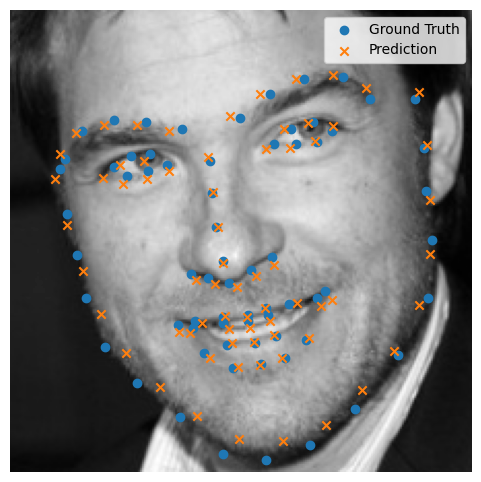

In [30]:
import matplotlib.pyplot as plt
import torch

# Chuyển model về eval mode và device phù hợp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# Lấy 1 batch đầu tiên từ test_loader
images, landmarks = next(iter(test_loader))

# Chọn ảnh và ground truth landmarks đầu tiên
img = images[0]                      # shape [1, H, W]
gt_landmarks = landmarks[0].view(-1, 2).cpu().numpy()

# Dự đoán landmarks
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
pred_landmarks = pred.cpu().view(-1, 2).numpy()

# Denormalize ảnh từ [-1, 1] về [0, 1] (nếu bạn đã dùng Normalize(mean=0.5, std=0.5))
img_np = img.squeeze(0).cpu().numpy() * 0.5 + 0.5

# Vẽ ảnh và landmarks
plt.figure(figsize=(6,6))
plt.imshow(img_np, cmap='gray')
# Ground‑truth (marker 'o')
plt.scatter(gt_landmarks[:,0], gt_landmarks[:,1], marker='o', label='Ground Truth')
# Prediction  (marker 'x')
plt.scatter(pred_landmarks[:,0], pred_landmarks[:,1], marker='x', label='Prediction')
plt.legend()
plt.axis('off')
plt.show()


/tmp/ipykernel_31/2412842034.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")


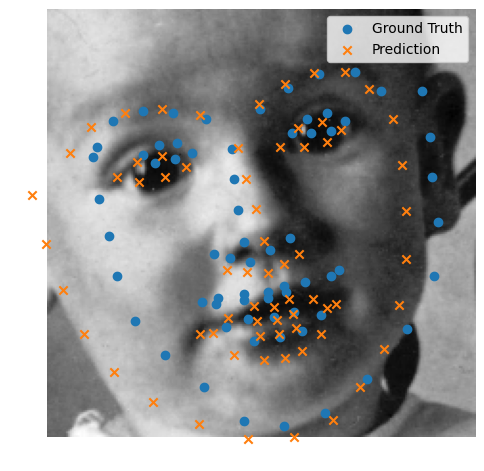

In [32]:
import matplotlib.pyplot as plt
import torch

# 1) Khởi tạo model và load state_dict
model = FacialLandmarksModel(learning_rate=1e-3)
checkpoint_path = "trained_models/facial_landmarks_model.pth"
state_dict = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(state_dict)

# 2) Đưa model về device và chế độ eval
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# 3) Lấy 1 batch đầu tiên từ test_loader
images, landmarks = next(iter(test_loader))

# 4) Chọn ảnh và ground truth landmarks đầu tiên
img = images[1]  # shape [1, H, W]
gt_landmarks = landmarks[0].view(-1, 2).cpu().numpy()

# 5) Chạy inference
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
pred_landmarks = pred.cpu().view(-1, 2).numpy()

# 6) Denormalize ảnh (nếu dùng Normalize(mean=0.5, std=0.5))
img_np = img.squeeze(0).cpu().numpy() * 0.5 + 0.5

# 7) Vẽ ảnh và landmarks
plt.figure(figsize=(6,6))
plt.imshow(img_np, cmap='gray')
plt.scatter(gt_landmarks[:,0], gt_landmarks[:,1], marker='o', label='Ground Truth')
plt.scatter(pred_landmarks[:,0], pred_landmarks[:,1], marker='x', label='Prediction')
plt.legend()
plt.axis('off')
plt.show()
